In [1]:

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [2]:
df = pd.read_csv('data/Annual snowfall in Buffalo 19101972.csv').set_index('year number')

### Скользящее среднее

In [3]:
df['MA_window_3'] = df['x'].rolling(window=3).mean()
df

,x,MA_window_3
year number,,
1,126.4,NaN
2,82.4,NaN
3,78.1,95.633333
4,51.1,70.533333
5,90.9,73.366667
...,...,...
59,66.1,73.300000
60,78.4,66.666667
61,120.5,88.333333


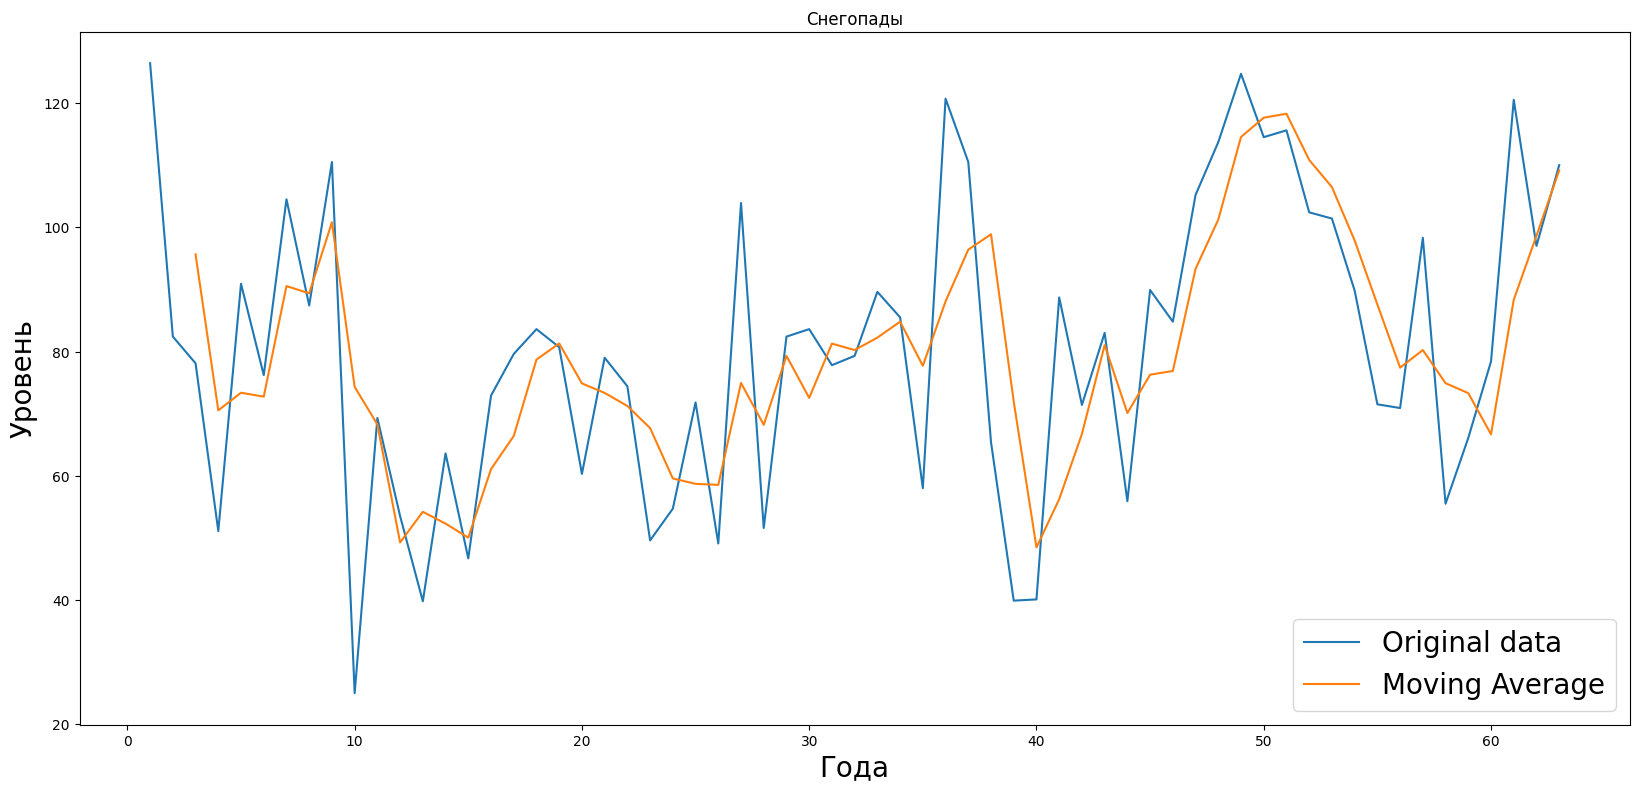

In [4]:
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_3'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('Снегопады')
plt.ylabel('Уровень', fontsize="20")
plt.xlabel('Года', fontsize="20")
plt.show()

Давайте напишем функцию, которая поможет нам понять тенденцию и движения временного ряда. Мы хотим видеть на графике некоторую скользящую статистику, такую как:

M скользящее среднее: невзвешенное среднее предыдущих n данных (также называемое скользящим средним).

Полосы Боллинджера: верхняя полоса в k раз на n -периодное стандартное отклонение выше скользящей средней и нижняя полоса в k раз на стандартное отклонение N ниже.

In [5]:
'''
Отрисовка скользящего среднего по медиане для ts с 95% доверительным интервалом для стандартного отклонения.
:parameter
  :param ts: датасет
  :param window: кол-во семплов в окне - для скользящих средних
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=100,
            figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='Реальные значения', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
                 color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                     color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

C:\Users\Gleb\AppData\Local\Temp\ipykernel_35488\3736708662.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


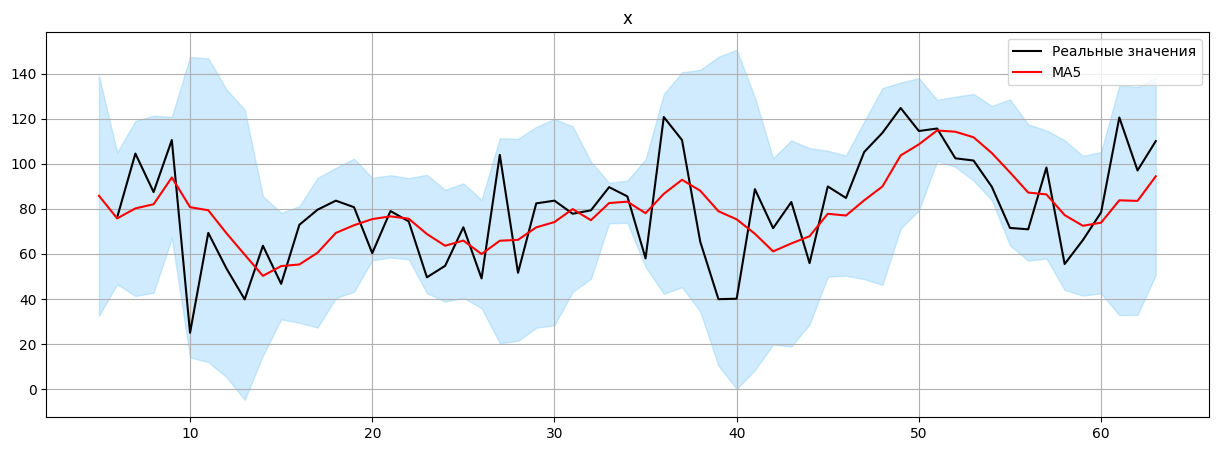

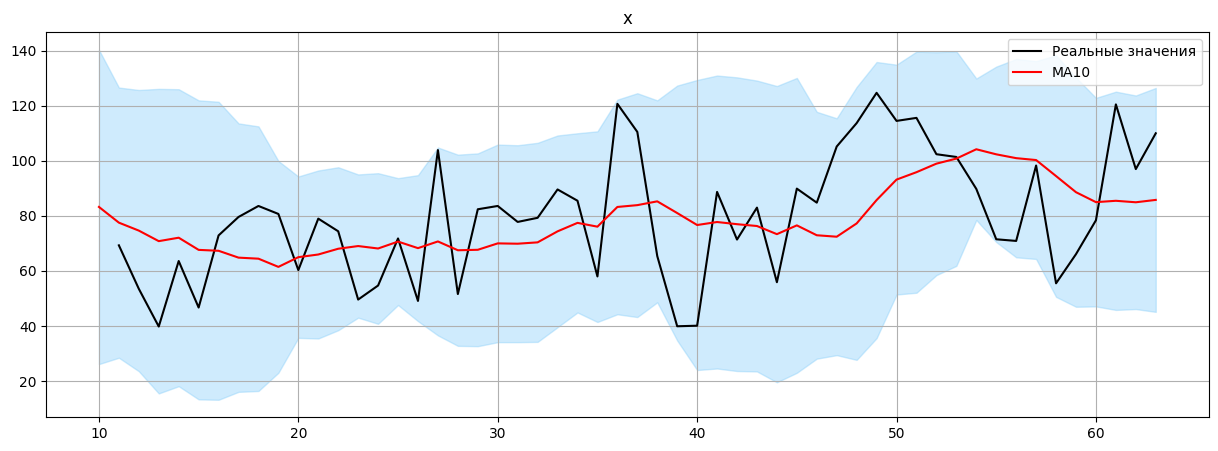

In [6]:
plot_ts(df["x"], window=5)
plot_ts(df["x"], window=10)

### ARMA

In [7]:
from statsmodels.tsa.arima.model import ARIMA

In [8]:
arma_model = ARIMA(df['x'], order=(5,0,3))
arma_model_fit = arma_model.fit()

c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Gleb\Desktop\psu stud

In [9]:
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                   63
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -281.498
Date:                Sat, 25 Nov 2023   AIC                            582.997
Time:                        20:10:57   BIC                            604.428
Sample:                             0   HQIC                           591.426
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.3720      5.021     16.206      0.000      71.531      91.213
ar.L1          1.1362      0.604      1.881      0.060      -0.048       2.320
ar.L2         -0.3283      0.970     -0.338      0.7

In [33]:
X = df['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [11]:
print(len(train))
print(len(test))
print(len(arma_predictions))

41
22
22


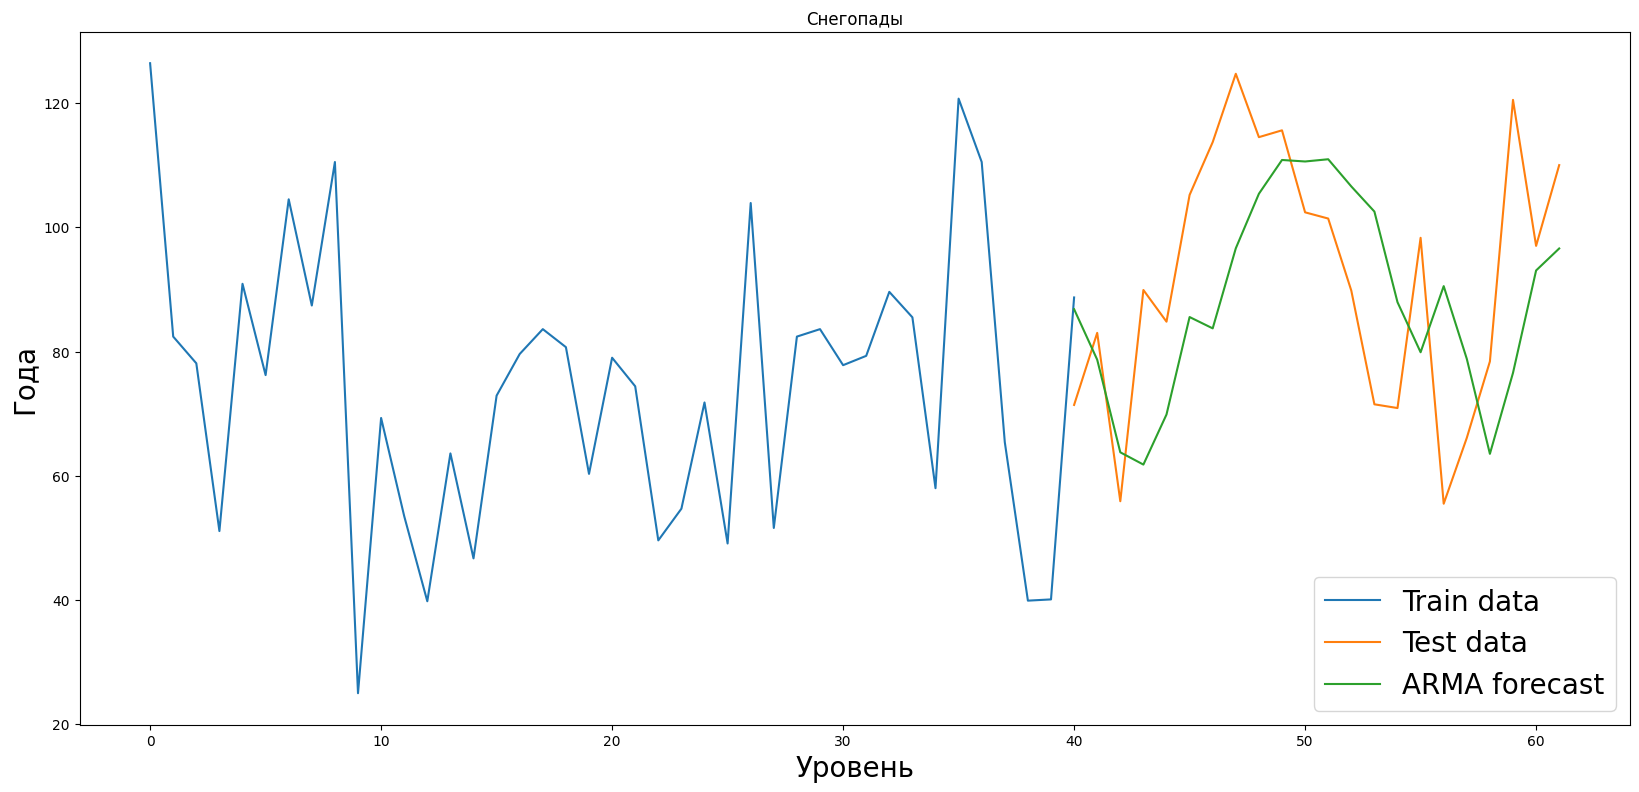

In [12]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')
plt.legend(fontsize="20")
plt.title('Снегопады')
plt.ylabel('Года', fontsize="20")
plt.xlabel('Уровень', fontsize="20")
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [38]:
print('Метрики для ARMA')
print("RMSE:", np.sqrt(mean_squared_error(test, arma_predictions)))
print("MAPE:", mean_absolute_percentage_error(test, arma_predictions))
print("MAE:", mean_absolute_error(test, arma_predictions))
print("R2: ", r2_score(test, arma_predictions))
smape = np.mean(np.abs(test - arma_predictions) / (np.abs(test + arma_predictions) / 2))
print('SMAPE: ', smape)

Метрики для ARMA
RMSE: 20.53594246356244
MAPE: 0.20259001372601756
MAE: 17.59787199458211
R2:  -0.019815543782176537
SMAPE:  0.2013526889543409


### ARIMA

In [39]:
arima_model = ARIMA(df['x'], order=(10,2,10))
arima_model_fit = arima_model.fit()

c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Gleb\Desktop\psu stud

In [14]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                   63
Model:               ARIMA(10, 2, 10)   Log Likelihood                -276.974
Date:                Sat, 25 Nov 2023   AIC                            595.948
Time:                        20:11:03   BIC                            640.277
Sample:                             0   HQIC                           613.321
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6223      4.965     -0.327      0.744     -11.353       8.109
ar.L2         -1.6347      3.092     -0.529      0.597      -7.695       4.426
ar.L3         -1.6624      2.422     -0.686      0.4

<Axes: xlabel='year number'>

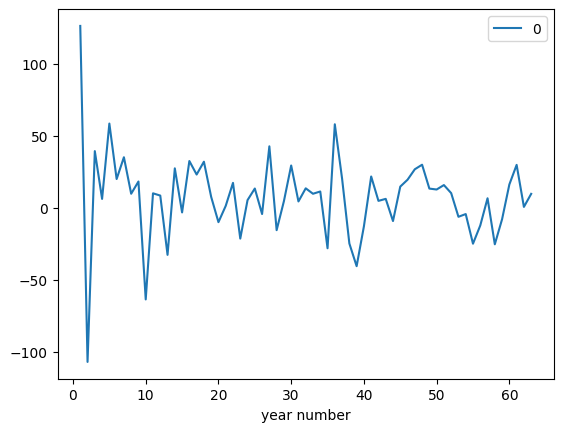

In [15]:
arima_residuals = pd.DataFrame(arima_model_fit.resid)
arima_residuals.plot()

In [16]:
# forecast предсказывает только следующее значение
output = arima_model_fit.forecast()

c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [40]:
X = df['x'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arima_predictions = list()
# walk-forward validation
for t in range(len(test)):
    arima_model = ARIMA(history, order=(10,2,5))
    arima_model_fit = arima_model.fit() 
    output = arima_model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Gleb\Desktop\psu studies\time_series\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

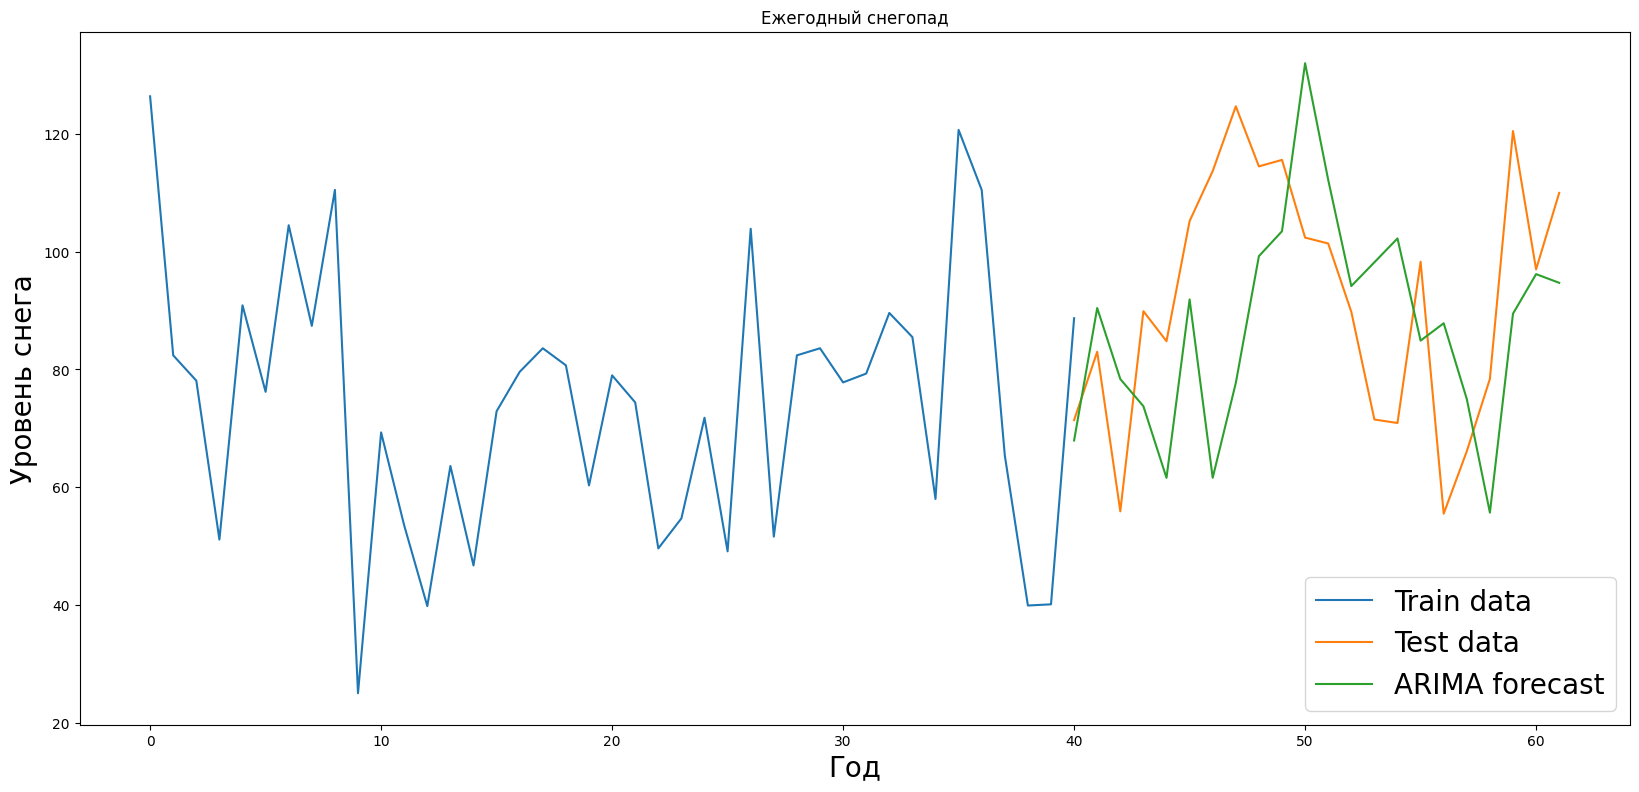

In [18]:
fig = plt.figure(figsize=(20, 9))
plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, len(X) - 1)], test, label='Test data')
plt.plot([i for i in range(size - 1, len(X) - 1)], arima_predictions, label='ARIMA forecast')
plt.legend(fontsize="20")
plt.title('Ежегодный снегопад')
plt.ylabel('Уровень снега', fontsize="20")
plt.xlabel('Год', fontsize="20")
plt.show()

In [42]:
print('Метрики для ARIMA')
print("RMSE:", np.sqrt(mean_squared_error(test, arima_predictions)))
print("MAPE:", mean_absolute_percentage_error(test, arima_predictions))
print("MAE:", mean_absolute_error(test, arima_predictions))
print("R2: ", r2_score(test, arima_predictions))
smape = np.mean(np.abs(test - arima_predictions) / (np.abs(test + arima_predictions) / 2))
print('SMAPE: ', smape)

Метрики для ARIMA
RMSE: 23.912470602326675
MAPE: 0.2273391671272771
MAE: 19.992530510562933
R2:  -0.38274229633768275
SMAPE:  0.22844254867203037


Сравним значения ARMA и ARIMA

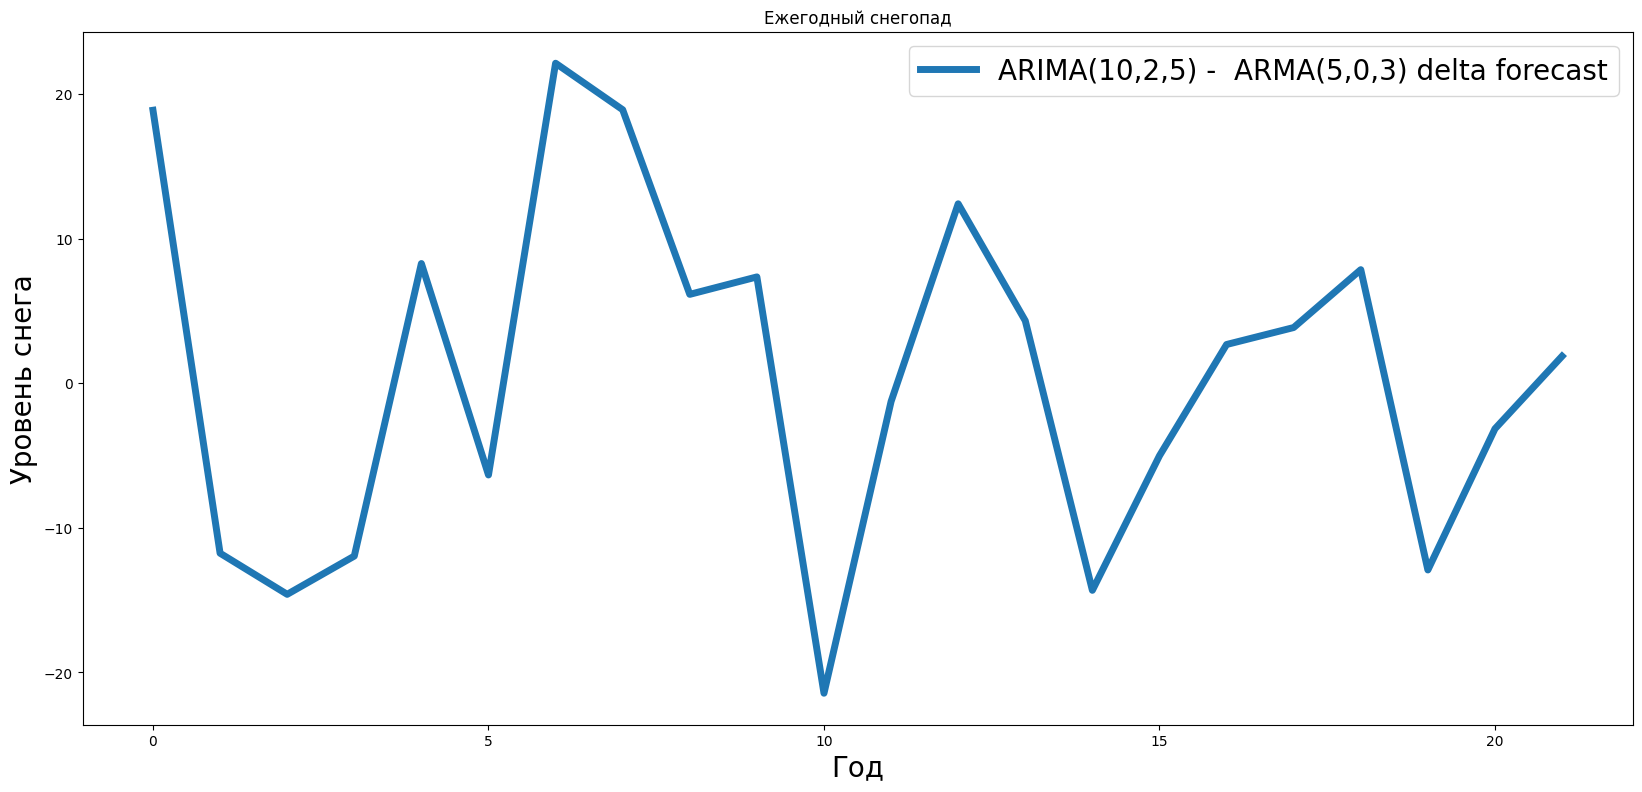

In [19]:
fig = plt.figure(figsize=(20, 9))

delta = []

for i in range(len(arima_predictions)):
    delta.append(arma_predictions[i] - arima_predictions[i])

plt.plot(delta, label='ARIMA(10,2,5) -  ARMA(5,0,3) delta forecast', linewidth=5)
plt.legend(fontsize="20")
plt.title('Ежегодный снегопад')
plt.ylabel('Уровень снега', fontsize="20")
plt.xlabel('Год', fontsize="20")
plt.show()

<Axes: xlabel='year number'>

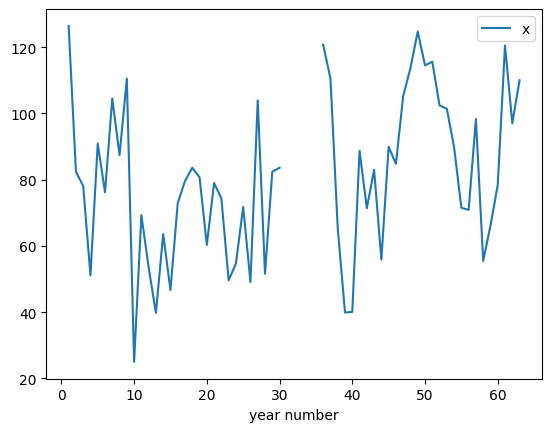

In [20]:
# Заполнение средним и медианой
df = pd.read_csv('data/Annual snowfall in Buffalo 19101972.csv').set_index('year number')
o_df = df.copy()

o_df["x"][30:35] = np.nan

o_df.plot()

Заполнение предыдущим и последующим значениями​

<Axes: title={'center': 'среднее из предыдущего и последующего'}, xlabel='year number'>

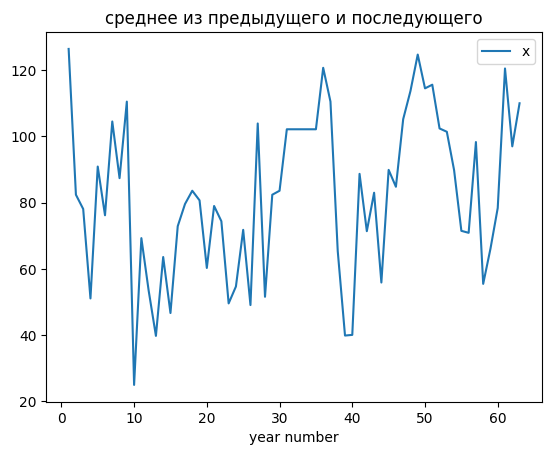

In [21]:
new_value = (o_df["x"][36] + o_df['x'][30]) / 2

o_df["x"][30:35] = new_value

o_df.plot(title='среднее из предыдущего и последующего')

<Axes: title={'center': 'Последующее значение'}, xlabel='year number'>

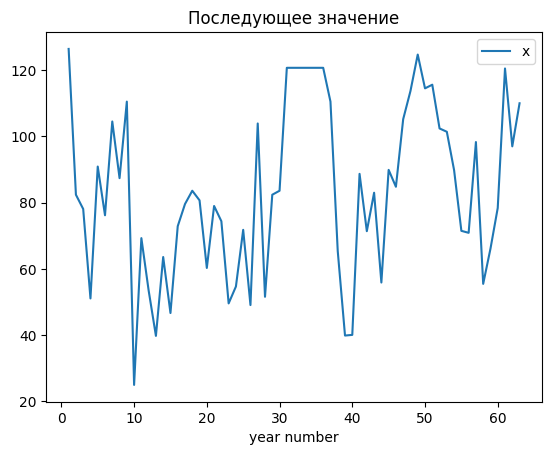

In [22]:
new_value = o_df["x"][36]

o_df["x"][30:35] = new_value

o_df.plot(title='Последующее значение')

<Axes: title={'center': 'Предыдущее значение'}, xlabel='year number'>

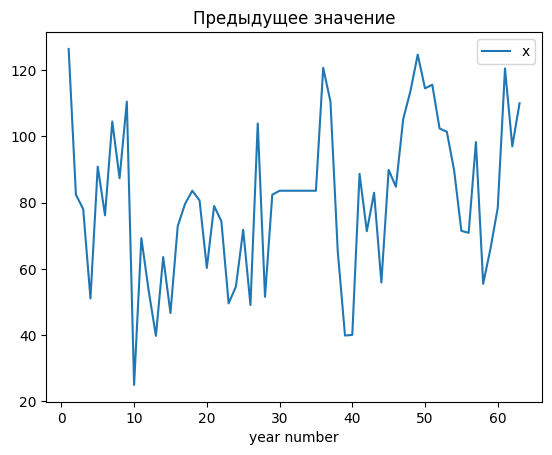

In [23]:
new_value = o_df["x"][30]

o_df["x"][30:35] = new_value

o_df.plot(title='Предыдущее значение')

Заполнение скользящим средним и медианой​

<Axes: title={'center': 'медиана'}, xlabel='year number'>

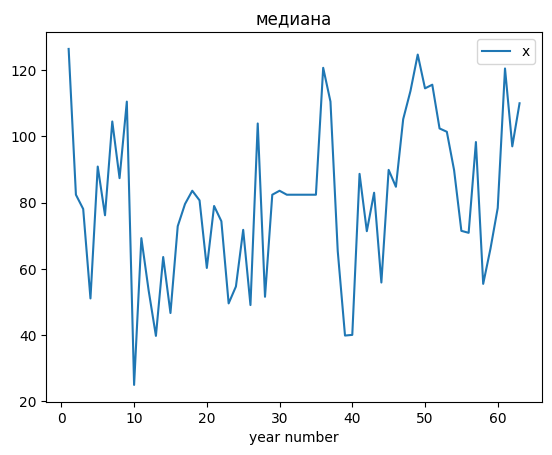

In [24]:
new_value = o_df["x"].median()

o_df["x"][30:35] = new_value

o_df.plot(title='медиана') 

<Axes: title={'center': 'среднее'}, xlabel='year number'>

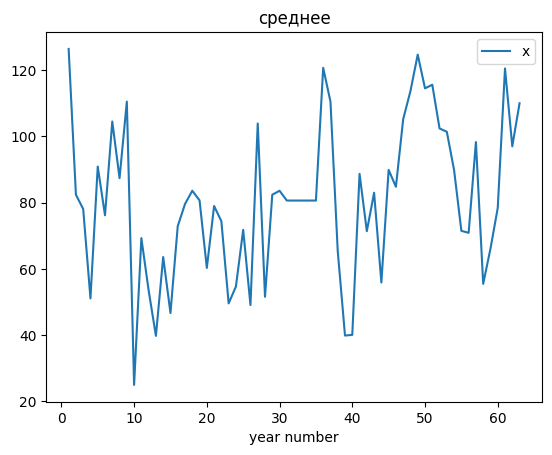

In [25]:
new_value = o_df["x"].mean()

o_df["x"][30:35] = new_value

o_df.plot(title='среднее') 

Интерполяция

<Axes: title={'center': 'zero'}, xlabel='year number'>

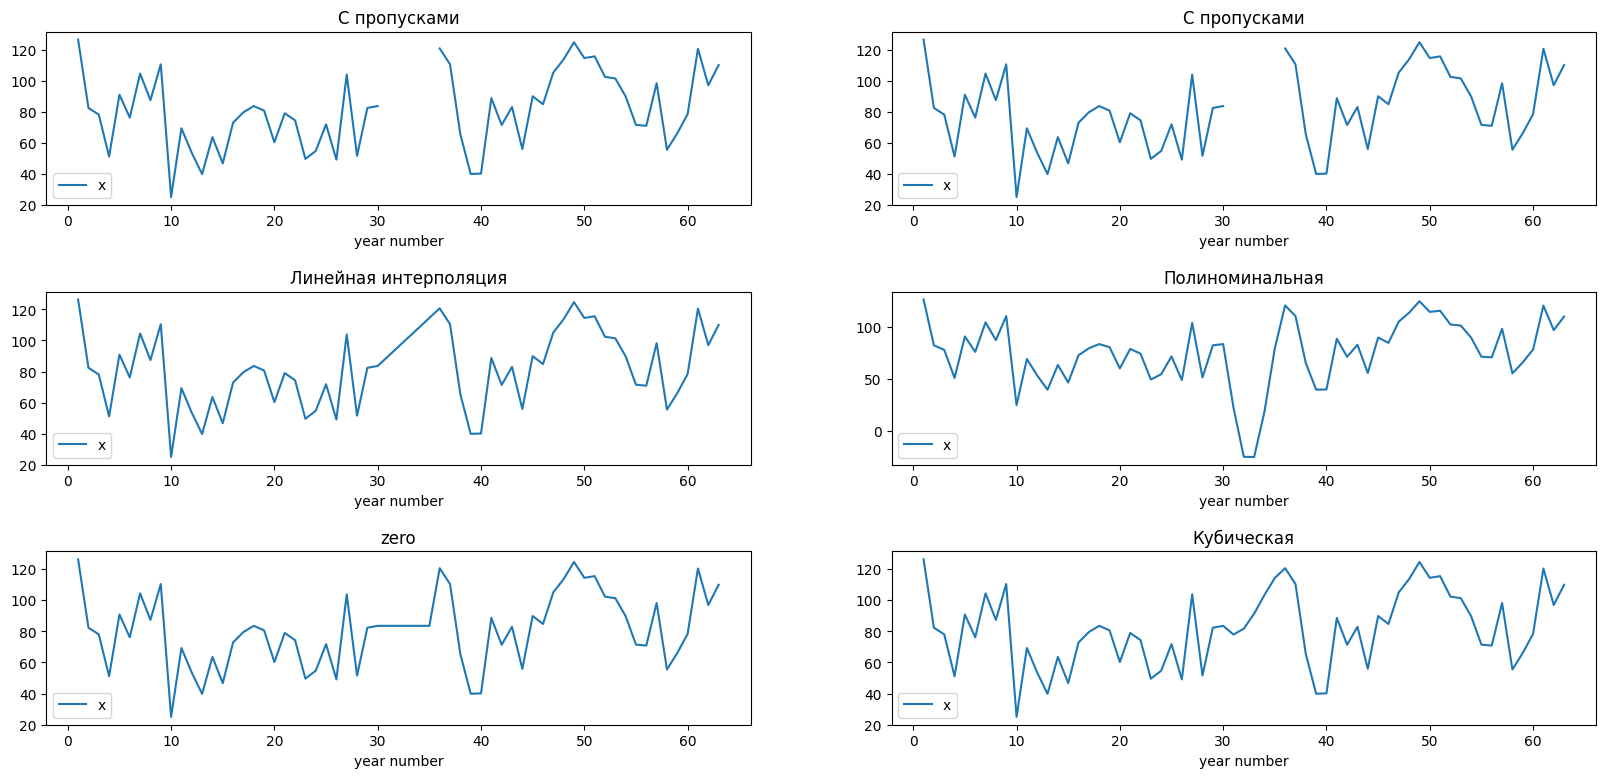

In [26]:
o_df["x"][30:35] = np.nan

lin_df = o_df.interpolate(method="linear")

cub_df = o_df.interpolate(method="cubic")

pol_df = o_df.interpolate(method="polynomial", order=5)

zero_df = o_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))
 
o_df.plot(title="С пропусками", ax = original_ax)  
o_df.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))  
lin_df.plot(title="Линейная интерполяция", ax = lin_ax) 
cub_df.plot(title="Кубическая", ax = cub_ax) 
pol_df.plot(title="Полиноминальная", ax = pol_ax) 
zero_df.plot(title="zero", ax=zero_ax)


In [27]:
import seaborn as sns

<Axes: >

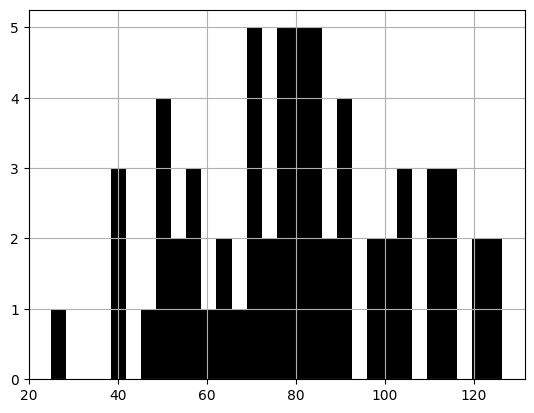

In [28]:
# гистограмма
df["x"].hist(bins=30, color="black")

Text(0.5, 1.0, 'Уровень снега')

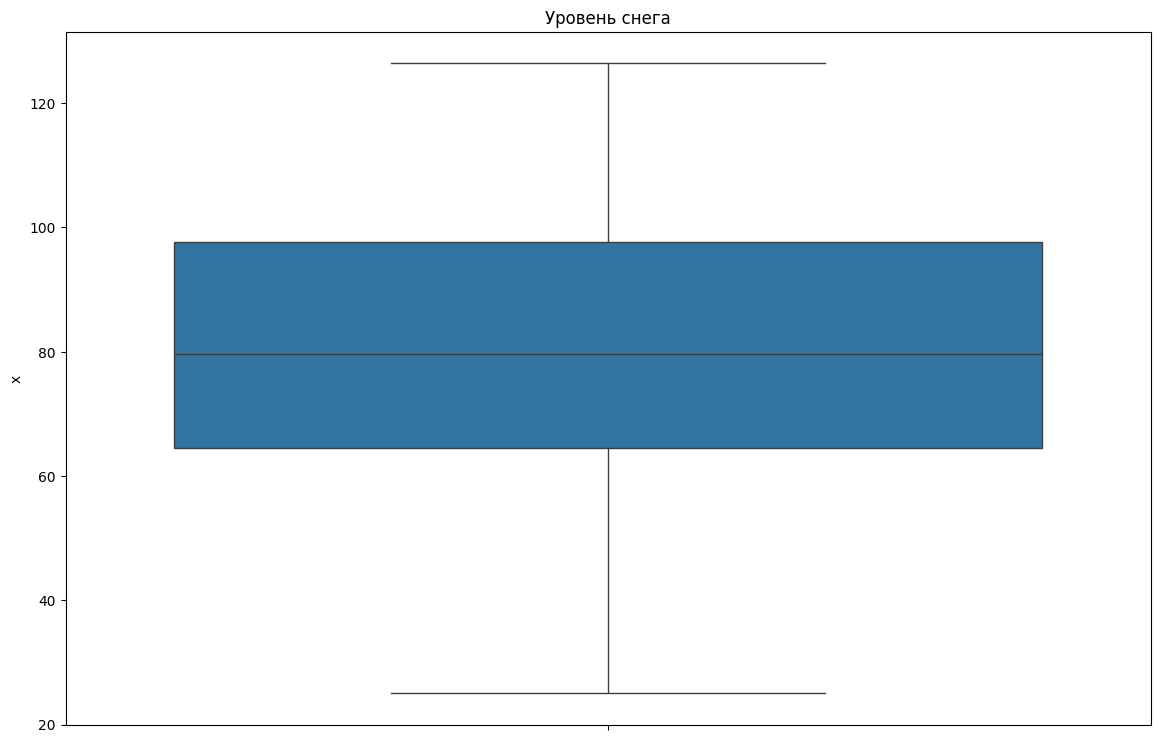

In [29]:
# ящик с усами
fig = plt.figure(figsize=(14, 9))
 
sns.boxplot(df.x).set_title('Уровень снега')

In [30]:
# обнаруживаем выбросы
from sklearn import preprocessing, svm

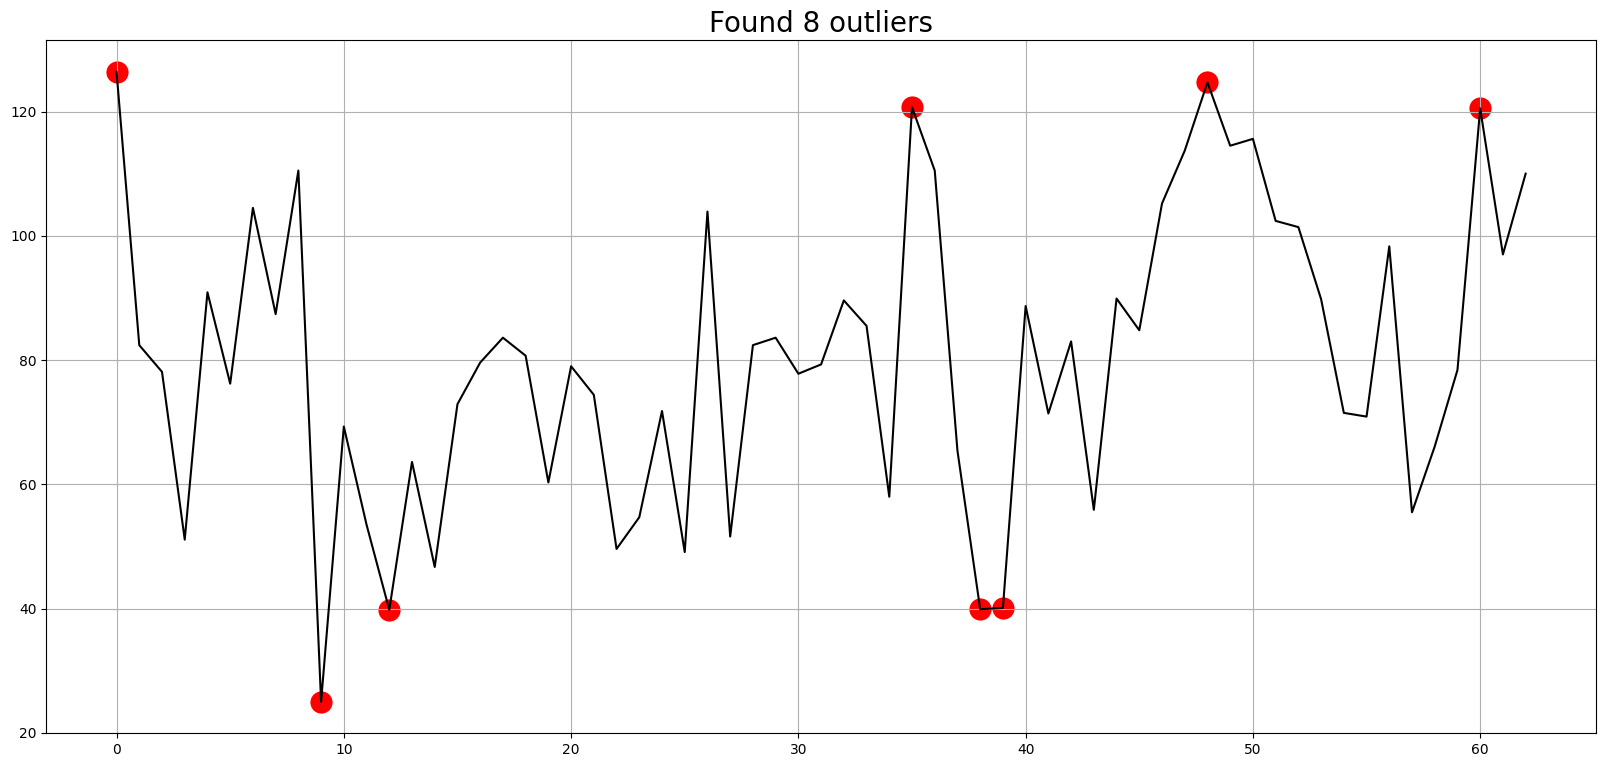

In [45]:
scaler = preprocessing.StandardScaler()
perc = 0.1

local_df = df["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)
## dtf output
dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                                            x: 1 if x==-1 else 0)
## plot
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

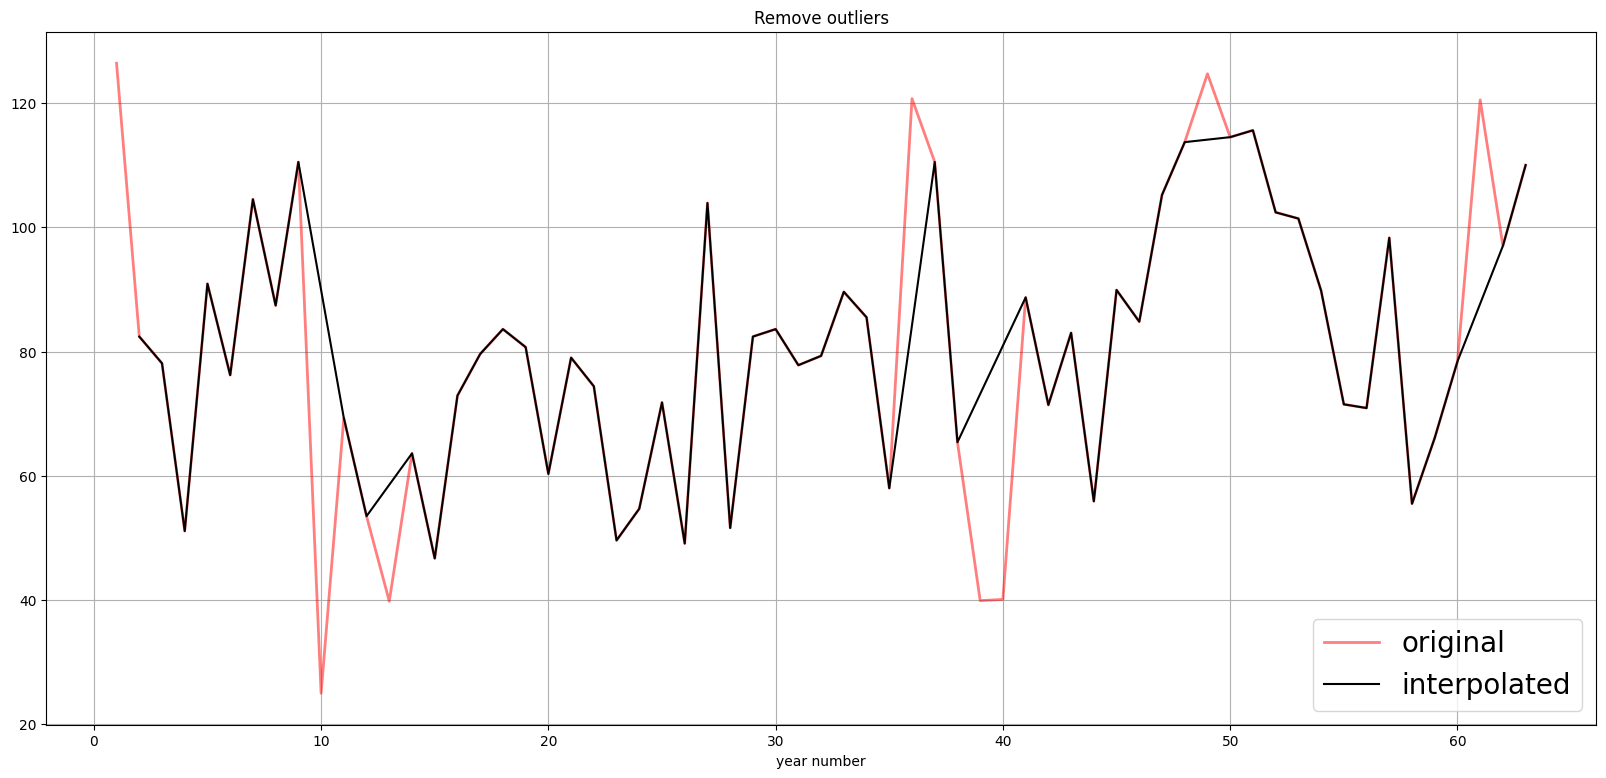

In [46]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Remove outliers", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()